## Importing libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import ReLU, LeakyReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Importing the dataset

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Data Cleaning and EDA

In [3]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'sadness', 5:'surprise', 6:'neutral'}

In [5]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

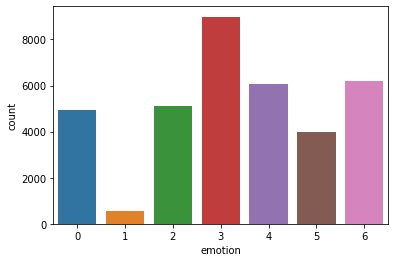

In [6]:
sns.countplot(df['emotion'])
plt.show()

Majority classes belongs to 3:Happy, 4:Sad and 6:Neutral. And we are also interested in these three classes only.

In [7]:
math.sqrt(len(df['pixels'][0].split(' ')))

48.0

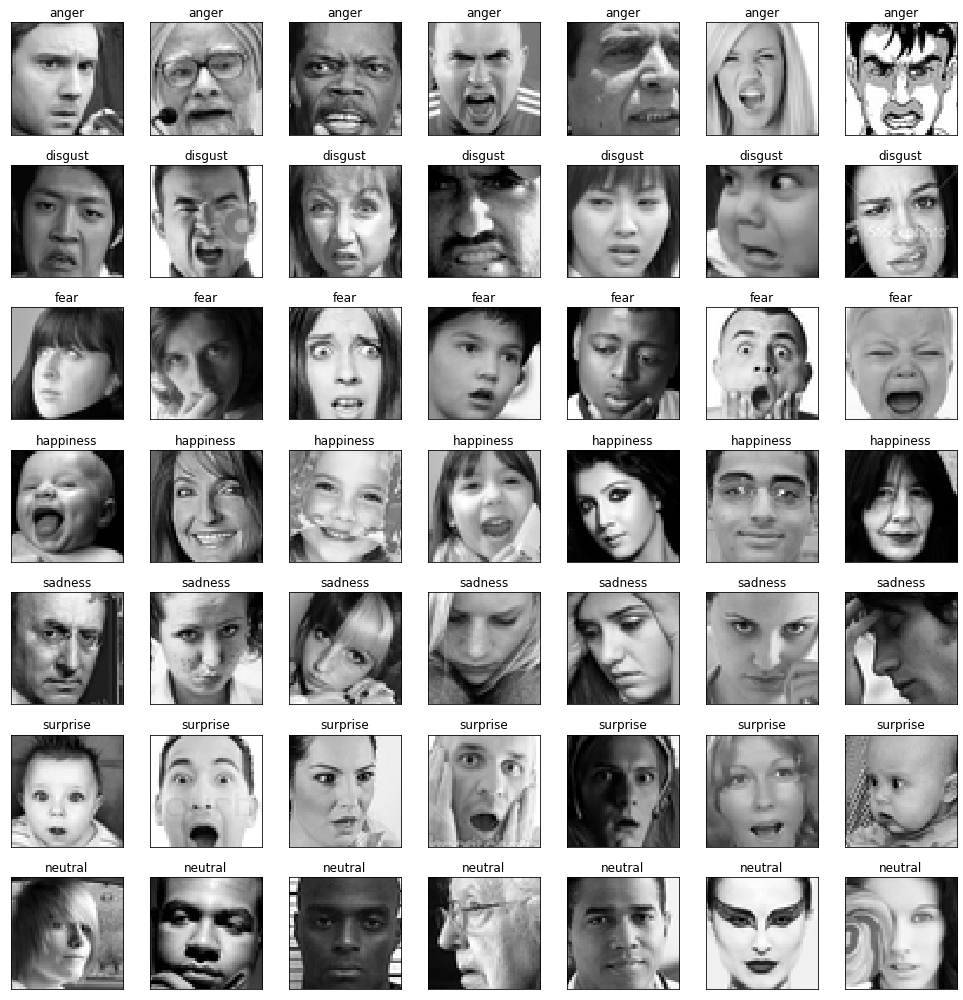

In [8]:
fig = plt.figure(1, (14,14))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion'] == label]['pixels'].iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [9]:
interested_labels = [3,4,6]

In [10]:
df = df[df['emotion'].isin(interested_labels)]
df.shape

(21264, 3)

In [11]:
df.head()

,emotion,pixels,Usage
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


## Making data compatible for neural networks

In [12]:
img_array = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [13]:
img_array.shape

(21264, 48, 48, 1)

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df['emotion'])
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


## Splitting the data into training and validation set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels,
                                                     test_size = 0.1, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
# Normalizing results as neural networks are sensitive to unnormalized data
X_train = X_train/255
X_valid = X_valid/255

## Building and training the model

In [20]:
def build_net(optim):
    net = Sequential(name='DCNN')
    
    net.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                  input_shape=(img_width, img_height, img_depth),
                  activation='elu',
                  padding='same',
                  kernel_initializer='he_normal',
                  name='conv2d_1'))
           
    
    net.add(BatchNormalization(name='batchnorm_1'))
    
    net.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                  activation='elu',
                  padding='same',
                  kernel_initializer='he_normal',
                  name='conv2d_2'))
    
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
        
    net.add(BatchNormalization(name='batchnorm_3'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
        
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
        
    net.add(BatchNormalization(name='batchnorm_5'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
        
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))
    
    net.add(Flatten(name='flatten'))
    
    net.add(Dense(
                128, 
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
                    )
           )
    
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(Dense(
                num_classes,
                activation='softmax',
                name='out_layer'
                )
           )

    net.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    net.summary()
    
    return net

In [21]:
# Using two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1)

callbacks = [early_stopping, lr_scheduler]

In [22]:
# As the data is little less, so we use ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=15, 
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  shear_range=0.15,
                                  zoom_range=0.15,
                                  horizontal_flip=True)

train_datagen.fit(X_train)

In [23]:
batch_size = 32
epochs = 100
optims = [optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
         optimizers.Adam(learning_rate=0.001)]

# difference in results of Nadam and Adam was not very much, so we go ahead with Nadam as it is more popular
model = build_net(optims[1])
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                             validation_data=(X_valid, y_valid),
                             steps_per_epoch=len(X_train)/batch_size,
                             epochs=epochs,
                             callbacks=callbacks
                             )

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

599/598 [==============================] - 670s 1s/step - loss: 0.4961 - accuracy: 0.7941 - val_loss: 0.4603 - val_accuracy: 0.8091
Epoch 35/100
599/598 [==============================] - 665s 1s/step - loss: 0.4948 - accuracy: 0.7952 - val_loss: 0.4588 - val_accuracy: 0.8152
Epoch 36/100
599/598 [==============================] - 655s 1s/step - loss: 0.4943 - accuracy: 0.7946 - val_loss: 0.4593 - val_accuracy: 0.8096
Epoch 37/100
599/598 [==============================] - 653s 1s/step - loss: 0.4894 - accuracy: 0.7958 - val_loss: 0.4401 - val_accuracy: 0.8148
Epoch 38/100
599/598 [==============================] - 656s 1s/step - loss: 0.4792 - accuracy: 0.8033 - val_loss: 0.4611 - val_accuracy: 0.8096
Epoch 39/100
599/598 [==============================] - 655s 1s/step - loss: 0.4813 - accuracy: 0.8023 - val_loss: 0.4600 - val_accuracy: 0.8124
Epoch 40/100
599/598 [==============================] - 657s 1s/step - loss: 0.4783 - accuracy: 0.8019 - val_loss: 0.4529 - val_accuracy: 0.822

In [24]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

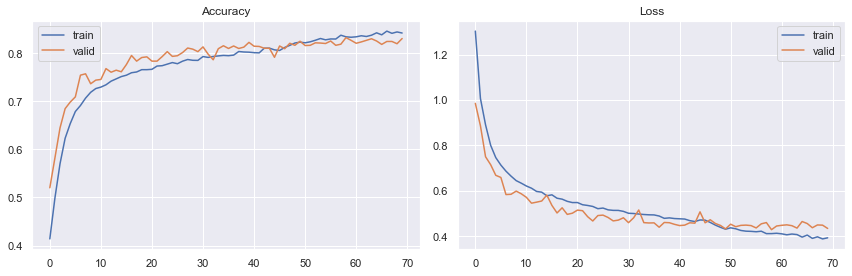

In [25]:
sns.set()
fig = plt.figure(0,(12,4))

ax = plt.subplot(1,2,1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

The epoch history shows that accuracy gradually increases and achieved +84% accuracy on both training and validation set. 

In [28]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


total wrong validation predictions: 357


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       899
           1       0.77      0.78      0.77       608
           2       0.75      0.75      0.75       620

    accuracy                           0.83      2127
   macro avg       0.82      0.82      0.82      2127
weighted avg       0.83      0.83      0.83      2127



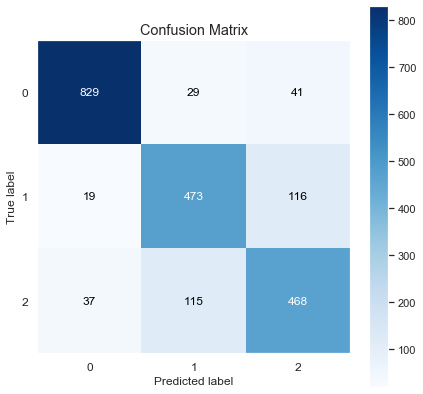

In [31]:
import scikitplot
import sklearn
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
plt.savefig('confusion_matrix_dcnn.png')

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(sklearn.metrics.classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. Some person's neutral face looks like sad.

In [32]:
mapper = {0: "happy", 1: "sad", 2: "neutral"}

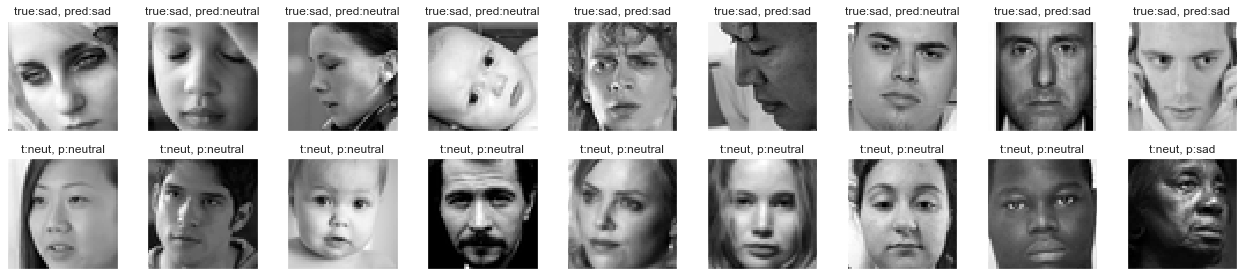

In [33]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        plt.tight_layout()